# Prosta Regresja Liniowa

W założeniu modelu liniowego podlegającego superwizji definiujemy dane wejściowe (input) i cele (target), zaś
wagi (weights), obciążenia (bias) i dane wyjściowe (output) pozwalamy wyciągnąć samej maszynie.

### 1. Import bibiliotek

In [49]:
import numpy as np
#Poniższe przyda się do wizualizacji w tym wypadku - TensorFlow ma swój TensorBoard do wizualizacji.
import matplotlib.pyplot as plt   # generator grafów - imho coś jak bokeh.
from mpl_toolkits.mplot3d import Axes3D # wizualizacja ww. w 3D.

In [50]:
### Centrum koordynacji zmiennych ###
observations = 1000  # Tu można zmienić ilość obserwacji. Optymalnie na lapka bez GPU jest 10.000 max. 100.000.
r_v = 10             # Tu ustawiasz sobie poziom szumu w bazie przypadków losowych. Im większa tym większy szum.
v_t = 1              # Tu zmieniasz wartość szumu w danych treningowych.
v_a = 1              # Podstawiasz tu liczbę zmiennych.
rng = 5              # Zakres działania animacji. Jeśli chcesz zobaczyć pełną animację wpisz dużą liczbę np. 200-300.
l_r = 0.02           # Prędkość nauki modelu.



### 2. Generowanie losowych danych do podstawienia do modelu.

In [51]:
xs = np.random.uniform(low = -r_v, high = r_v, size =(observations,v_a)) # funkcja generowania liczb losowych w numpy.
# Od -10 do 10 z równą szansą dla każdej. rozmiar to liczba obserwacji / liczba zmiennych
zs = np.random.uniform(-r_v,r_v,(observations,v_a)) # ta sama funkcja, druga kolumna i bez opisu wewnątrz.

inputs = np.column_stack((xs,zs)) # Ta funkcja łączy dwie kolumny ze sobą - w ten sposób będzie wyglądać input w TF.
# W tym wypadku mamy do czynienia z matrycą 1000x2.

print(inputs.shape) # Drukuje kształt matrycy. Tutaj użyte jako sanity check.

(1000, 2)


### 3. Utworzenie celów do których ma dążyć maszyna

In [52]:
noise = np.random.uniform(-1,1,(observations,1)) # Generuje 'szum' w danych docelowych. 
# Kiedy zapewniamy maszynie próbkę danych to one nigdy nie są idealne i to reprezentuje ten niewielki szum.

targets = 2*xs - 3*zs + 5 + noise # Tę funkcję ma 'odkryć' maszyna ucząc się z naszych danych. 
# W ten sposób mówimy, że wagi mają mieć 2 i -3 a błąd 5. Jest to wektor 1000x1.

print(targets.shape) # Kolejny sanity check, żeby sprawdzić, czy dobrze zdefiniowaliśmy cele.

(1000, 1)


### 4. Tworzenie grafu 3D dla podglądu danych treningowych

Chodzi tu o to, żeby zobaczyć na wykresie czy występuje tu trend jaki chcieliśmy uzyskać.

In [53]:
def graph_animator(var, observations, targets,):
    # Używanie matplotlib - typowa składnia.

    # Zadeklarowanie grafu
    fig = plt.figure()

    # Metoda tworząca graf 3d
    ax = fig.add_subplot(111, projection='3d')

    # Dobór osi
    ax.plot(xs, zs, targets)

    # Dobór nazw osi.
    ax.set_xlabel('xs')
    ax.set_ylabel('zs')
    ax.set_zlabel('Targets')
    

    # Azymut pozwala oglądać dane z różnych stron. Można się tym pobawić. Np. azim = 0 lub 200.
    ax.view_init(azim = 120 + var)

    # Pokaż graf.
    print(var)

    plt.show()

0


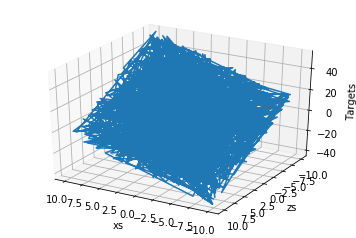

1


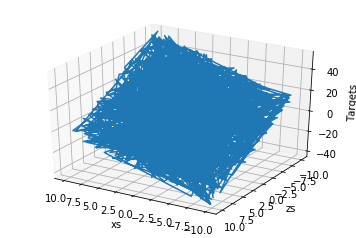

2


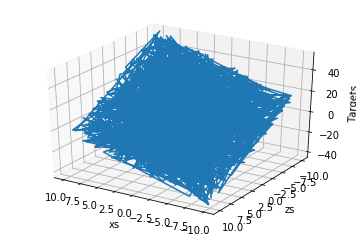

3


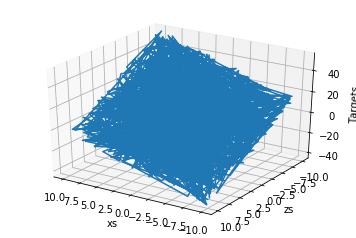

4


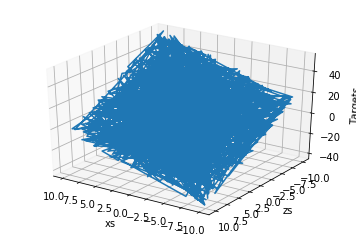

In [54]:
# To taka moja mała animacja ad-hoc, bo lubię widzieć co się dzieje w środku, 
    # a tak znacznie łatwiej to sobie zwizualizować. :P
    # Jak masz przedpotopowy sprzęt jak ja i nie masz GPU (karty graficznej), którą
    # dałoby się taki proces przysipieszyć, to polecam nie odpalać navigatora anakondy,
    # a najlepiej w ogóle zrezygnować ze środowiska graficznego i poruszać się po systemie przy pomocy basha.
    # Naturalnie jeśli Twój komputer nie dostaje zadyszki przy milionie rekordów w bazie, to pewnie
    # nie masz się czym przejmować. Ja zbieram teraz na jakiś porządny sprzęt z kartami "tesla" albo na ten procesor
    # co to ma być tylko do obsługi SI a jednak bardziej wydajny niż GPU.

    # Używamy .reshape żeby przygotować cele pod graf.
    # reshape jest w docsach do numpyego. Jako argumenty przyjmuje wymiary, którymi chcemy opisać obiekt.
targets = targets.reshape(observations,)

#Ta funkcja powiela graf tyle razy ile tego sobie życzę.
for i in range(rng): #Zmień to sobie na większą wartość jeśli masz zasoby i chcesz z tego zrobić 'animację'.
                   #Ja wpisałem 300 i obracało się całkiem nieźle.
    graph_animator(i,observations,targets)
    
# Przywracamy poprzedni kształt celom, żeby można ich ponownie użyć do nauki.
# Równie dobrze można było je przepisać na nową zmienną np. 'targets_plot' i teraz tego nie robić
# ale warto znać i metodę odwrotną tak na wszelki wypadek. Pytanie co jest mniej zasobochłonne.
targets = targets.reshape(observations,1)

### 5. Inicjalizowanie zmiennych

In [55]:
# Zmienna do podstawienia do funkcji generującej losowo startowe wagi i błędy. Na starcie będzie +/- tyle.
    # Można się z tym pobawić, ale jak ustawisz za dużo, to algorytm się zawiesi. Lepiej nie ruszać w ogóle.
init_range = 0.1

# Wagi mają wymiar k x m, gdzie k to ilość zmiennych wejściowych (tutaj 2 - x,z), a m to ilość zmiennych wyjściowych
    # (tutaj 1 - y). Logicznie matryca wag ma u nas wymiar 2x1.
weights = np.random.uniform(low=-init_range, high=init_range, size=(2, 1))

# Mamy jedno obciążenie, gdyż jest tylko jeden output. Obciążenie to skalar.
biases = np.random.uniform(low=-init_range, high=init_range, size=1)

#Sanity check. Zwraca wagi i obciążenia, żeby mieć ogląd na sposób ich inicjalizacji.
wagi = "wagi: %s" % weights
obci = "obciążenia: %s" % biases
print (wagi)
print (obci)

wagi: [[-0.09445278]
 [ 0.04001408]]
obciążenia: [-0.02447674]


### 6. Ustalanie prędkości uczenia się modelu

Ogólnie przy MNIST od Hindusa używałem 0.01 i strasznie muliło, ale w 30 krokach robiło robotę.
Warto się z tym pobawić. Zwłaszcza przy prostszych modelach, albo mocniejszych maszynach.
Ostatecznie zawsze można przerwać operacje i zmienić wartość na większą a mniej dokładną.

In [56]:
learning_rate = l_r # Amerykanie polecają tyle do tego modelu, ale się przy tym nie upierają.
                     # Dla mnie najlepsze osiągi dawała baza 10.000 rekordów i czułość 0.03-0.04.

In [57]:
# Wykonujemy 100 iteracji na naszym zestawie treningowym. Do ww parametrów było jak znalazł.
    # Ogólnie rzecz biorąc jest to nieco bardziej skomplikowane i jeszcze się tym zajmiemy,
    # ale to co musimy na tym etapie wiedzieć, to to, że wzraz ze wzrostem prędkości_uczenia potrzebujemy mniej iteracji,
    # podczas gdy wraz jej spadkiem ilość iteracji potrzebnych do osiągnięcia podobnych wyników wzrasta.
        # Miej również na względzie, że zbyt wysoka prędkość nauki (learning_rate) może sprawić, 
        #że strata będzie dązyć do nieskończoności, zamiast do zera.
for i in range (100):
    
# To jest równanie modelu liniowego: y = xw + b
    # Tzn. ujścia = żródła * wagi + obciążenia.
    outputs = np.dot(inputs,weights) + biases
# Delty (deltas) to różnice pomiędzy ujściami i celami.
    # Zwróć uwagę, że tutaj delty są wektorami 1000 x 1.
    deltas = outputs - targets
    
# Bierzemy się za normę straty L2, którą dzielimy przez 2 i jeszcze przez liczbę obserwacji.
    # Chodzi tu po prostu o przeskalowanie przez stałą. Taka operacja nie zmienia logiki optymalizacji,
    # gdyż każda funkcja, która jako swoją podstawową właściwość ma to, że traci na wartości,
    # w miarę poprawiania się wyników modelu (i vice-versa tj. przy wzroście wartości funkcji wyniki się pogarszają)
    # MOŻE być użyta jako funkcja straty. Tj. liczą się tu proporcje różnic a nie wartości bezwzględne.
    loss = np.sum(deltas ** 2) / 2 / observations
    
    # Przy każdej iteracji zwracamy funkcję straty, dzięki czemu mamy podgląd na to czy spada tak jak oczekujemy.
    print (loss)
    
# Delty również podlegają skalowaniu w taki sam sposób jak funkcja straty.
    # Mam na myśli, że w ten sposób można prędkość nauki (learning_rate) ooderwać od ilości przypadków (observations)
    # To znowu nie zmieni to logiki działania programu, ale z kolei ułatwia dobrać pojedynczą prędkość nauki
    # która pozostanie taka sama, bez względu na ilość próbek (observations).
    # Możesz spróbować rozwiązać ten problem bez przeskalowywania i zobaczyć jak Ci to odpowiada.
    deltas_scaled = deltas / observations

# Koniec końców stosujemy zasadę aktualizacji gradientu prostego. Wagi to 2x1, prędkość uczenia się jest skalarem,
    # źródła są 1000x2 a wyskalowane delty (deltas_scaled) 1000x1.
    # Transponujemy źródła (co jest dozwolone), aby móc wykonać operację tj będą teraz 2x1000. To  skraca się
    # z 1000x1 i mamy 2x1.
    weights = weights - learning_rate * np.dot(inputs.T,deltas_scaled)
    biases = biases - learning_rate * np.sum(deltas_scaled)
    
    # Wagi są aktualizowane zgodnie z zasadami algebry liniowej (macierz minus inna macierz)
    # Obciążenia sę tu jednak pojedynczą liczbą, więc musimy przetransformować delty na skalar.
    # Obydwie linijki są zgodne z metodologią gradientu prostego.

255.53274447751411
32.73400401191302
13.595451590272635
11.565621255994742
10.98856596737001
10.549581673893933
10.137656579376067
9.742854742916196
9.363753161902627
8.999667515203328
8.64999797776138
8.314173310958452
7.991645302521654
7.6818874808014534
7.384394222251449
7.098679923259602
6.824278207244515
6.560741163359181
6.307638615356142
6.064557419402889
5.831100789699757
5.606887650799346
5.391552015570223
5.1847423877895515
4.986121188389496
4.795364204420868
4.6121600598344905
4.436209707216487
4.267225939647829
4.104932921891315
3.9490657401407696
3.7993699695974783
3.6556012591680185
3.5175249326055917
3.384915605443766
3.2575568170973686
3.1352406775299886
3.0177675279113334
2.9049456147105426
2.7965907766934497
2.692526144312901
2.5925818510014222
2.496594755894952
2.4044081775351045
2.3158716381151963
2.2308406178526305
2.149176319086657
2.0707454397164557
1.9954199556097323
1.9230769116266269
1.853598220917828
1.7868704721692927
1.72278474447892
1.6612364295630102
1.60

In [58]:
# Zwracamy wagi i obciążenia, żebyśmy mogli zobaczyć na ile otrzymaliśmy to co chcieliśmy.
# Gdy deklarowaliśmy cele, wiedzieliśmy, że wagi powinny mieć odpowiednio 2 i -3 a obciążenie 5.
print (weights, biases)

# Może być tak, że funkcja nie osiągnąła jeszcze minimum i potrzeba jej więcej iteracji.


[[ 2.0008832 ]
 [-3.00203839]] [4.35012387]


### Rzut wyników na cele

Reprezentuje dokładność modelu. Im bliżej mu do linii pod kątem 45* tym bardziej liniowa jest zależność
między celami a wynikami zwracanimy przez funkcję.


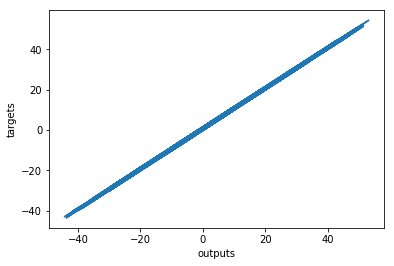

In [59]:
# Zwracamy ujścia i cele aby zobaczyć czy jest między nimi liniowa zależność.
# Nie jest to konieczne, a potem nawet nie będzie możliwe do wykonania.
plt.plot(outputs,targets)
plt.xlabel('outputs')
plt.ylabel('targets')
plt.show()